# **Engineering a Kerr-based Deterministic Cubic Phase Gate via Gaussian Operations in Strawberry Fields**

In [1]:
import strawberryfields as sf
from strawberryfields.ops import *

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

### **Define Useful Functions**

In [12]:
def plot_wigner(state, title = "Wigner Function of State", fig=None, ax=None):
    if fig == None:
        fig = plt.figure()
    x = np.linspace(-20, 20, 100)
    p = np.linspace(-20, 20, 100)
    Z = state.wigner(0, x, p)
    X, P = np.meshgrid(x, p)
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, P, Z, cmap='RdYlGn', lw=0.5, rstride=1, cstride=1)
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('P')
    fig.tight_layout()
    
    plt.show()
    
def ax_plot_wigner(ax, state, title):
    x = np.linspace(-20, 20, 100)
    p = np.linspace(-20, 20, 100)
    Z = state.wigner(0, x, p)
    X, P = np.meshgrid(x, p)
    ax.plot_surface(X, P, Z, cmap='RdYlGn', lw=0.5, rstride=1, cstride=1)
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('P')

### **Define Parameters**

In [3]:
""" Hyperparameters """
N = 5000 # discretization order
cutoff_dim = 20 # Fock basis truncation

""" Cubic Phase Gate """
gamma = 0.7 # target gate angle


""" Squeezing and Displacement """
lam = 100 # in-phase quadrature power gain = lab^2
alpha = 4 # displacement amplitude - how much we displace the state along x

# convert alpha to polar coordinates
r = np.abs(alpha)
phi = np.angle(alpha)

""" Nonlinearity """
# medium
chi = 200 # nonlinearity strength

detuning = 3 * chi * alpha**2 - chi # detuning, based on appropriate choice for cubic phase gate
drive = -2 * chi * alpha**3 # drive, based on appropriate choice for cubic phase gate

# gate time
t = np.sqrt(2) * gamma / (chi * alpha * lam**3)
dt = t / N

# parameters for the cubic phase gate step
nkappa = chi/2.0 * dt
nphi = -detuning * dt

nr = drive * dt
nphi = 3*np.pi / 4

### **Run Program**

Within the program we implement driven Kerr Hamiltonian
$$
\hat{H}_{\text{Kerr}} = -\frac{\chi}{2} \hat{a}^\dagger{}^2 \hat{a}^2 + \delta \hat{a}^\dagger \hat{a} + \beta (\hat{a} + \hat{a}^\dagger)
$$
and approximate its propagator for a small timestep $dt$ as
$$
\hat{U}_{dt} = e^{-i[-\frac{\chi}{2} \hat{a}^\dagger{}^2 \hat{a}^2 + \delta \hat{a}^\dagger \hat{a} + \beta (\hat{a} + \hat{a}^\dagger)]dt} \approx e^{i\frac{\chi}{2} \hat{a}^\dagger{}^2 \hat{a}^2dt} e^{-i\delta \hat{a}^\dagger \hat{a}dt} e^{-i\beta (\hat{a} + \hat{a}^\dagger)dt} = K(\frac{\chi}{2}dt)R(-\delta dt)D(\beta dt e^{i\frac{3 \pi}{4}})
$$

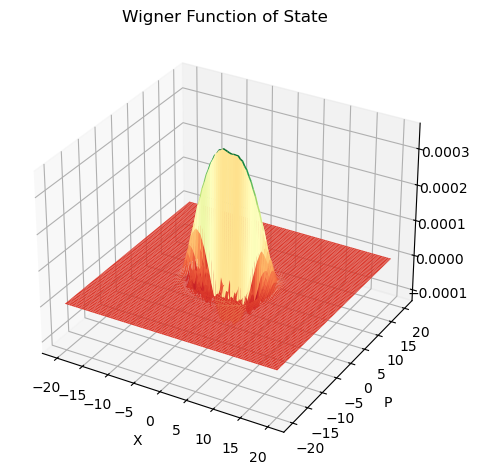

In [4]:
prog = sf.Program(1)
with prog.context as q:
    Vac | q[0] # prepare the vacuum state |0>
    
    """ Direct """
    Sgate(np.log(lam), 0) | q[0] # apply the squeezing
    Dgate(r, phi) | q[0] # apply the displacement
    
    """ Nonlinearity """
    for i in range(N): # apply the small propagation step N times
        
        Kgate(nkappa) | q[0]
        Rgate(nphi) | q[0]
        Dgate(nr, nphi) | q[0]
        
        
    
    """ Inverse """
    Dgate(-r, phi) | q[0]
    Sgate(-np.log(lam), 0) | q[0]
    
    
eng = sf.Engine('fock', backend_options={"cutoff_dim": cutoff_dim}) 
state = eng.run(prog).state
plot_wigner(state)

### **Testing**

#### **Case 1: Instability of Fock Backend When Squeezing States**

When squeezing a state and using the `fock` backend instead of the `gaussian` backend, for high squeezing we get very different results.

Upon looking into this it seems that this is a known issue: 
- [Forum discussion](https://discuss.pennylane.ai/t/wigner-calculation-unstable-for-the-fock-backend/2293/3)

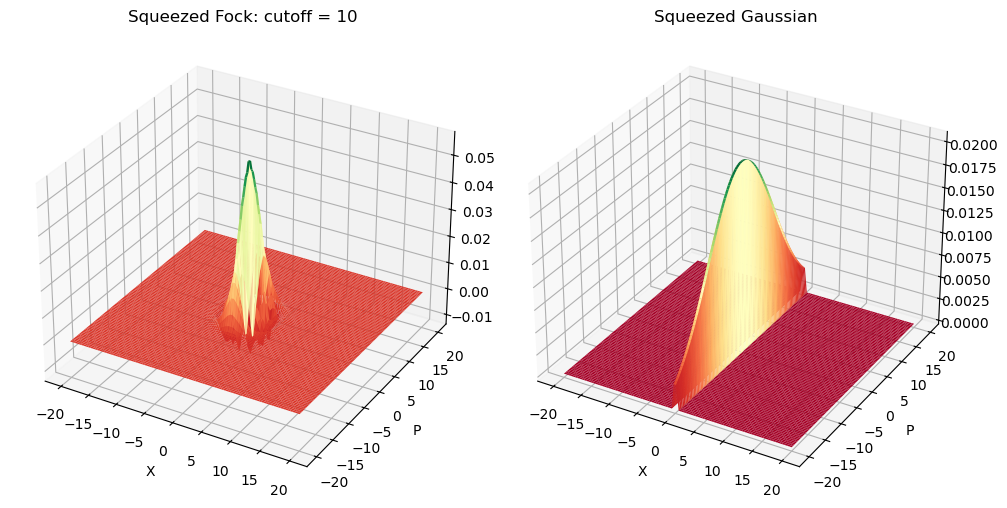

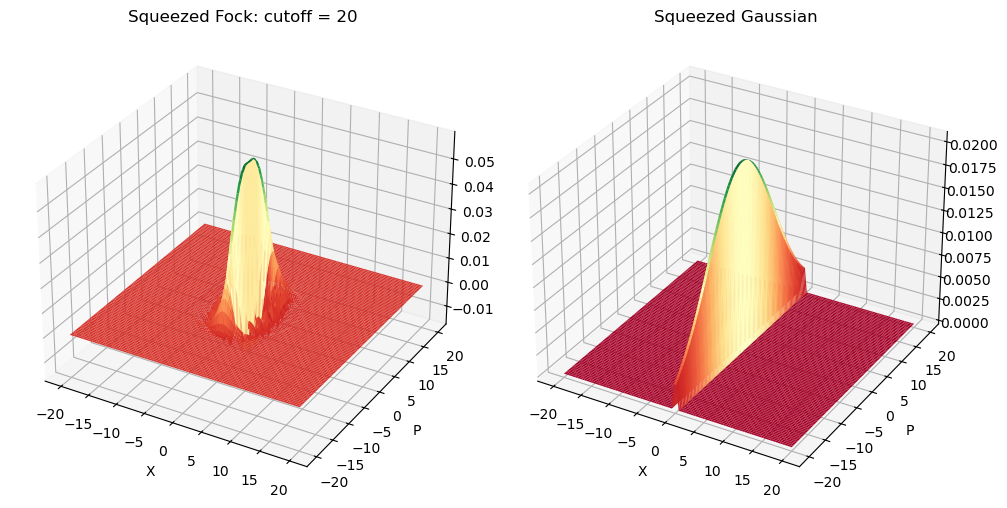

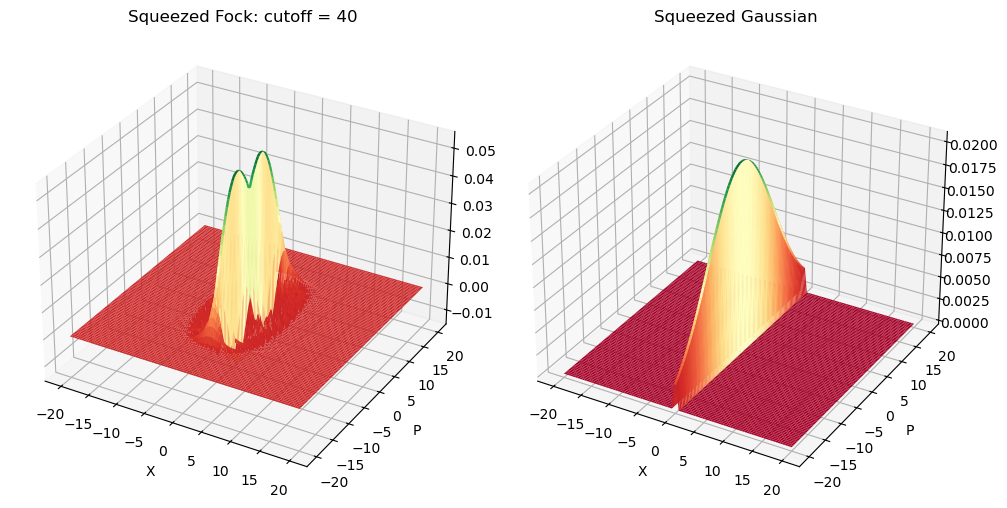

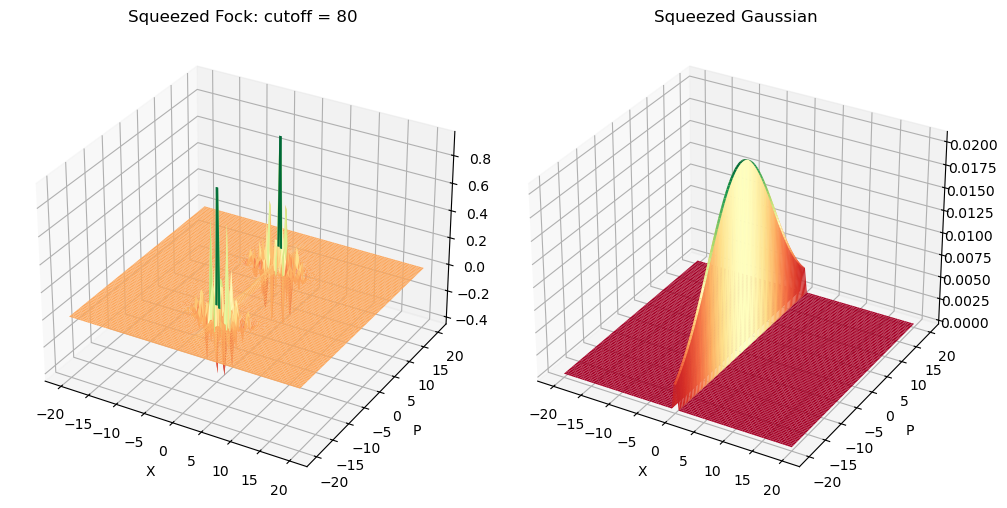

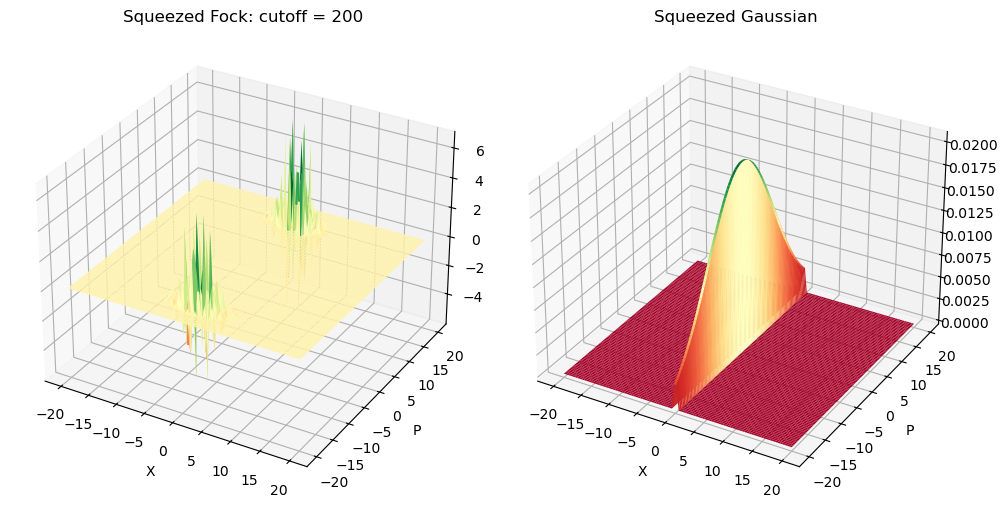

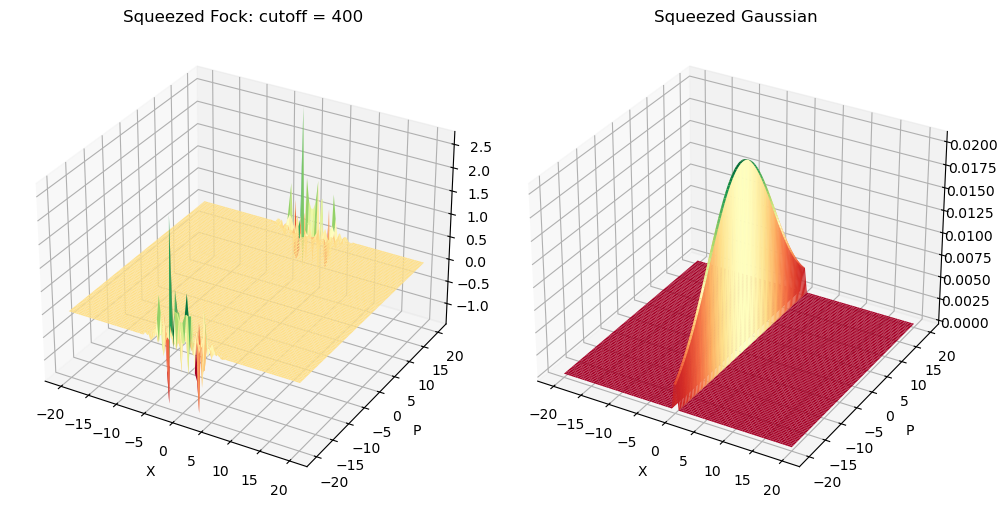

In [23]:
lam = 10.0
cutoff_dim = [10, 20, 40, 80, 200, 400]

def squeeze_fock(lam, cutoff_dim):
    prog = sf.Program(1)
    with prog.context as q:
        Vac | q[0] # prepare the vacuum state |0>

        """ Direct """
        Sgate(np.log(lam), 0) | q[0] # apply the squeezing

    eng = sf.Engine('fock', backend_options={"cutoff_dim": cutoff_dim}) 
    state = eng.run(prog).state
    return state

def squeeze_gaussian(lam, cutoff_dim):
    prog = sf.Program(1)
    with prog.context as q:
        Vac | q[0] # prepare the vacuum state |0>

        """ Direct """
        Sgate(np.log(lam), 0) | q[0] # apply the squeezing

    eng = sf.Engine('gaussian') 
    state = eng.run(prog).state
    return state

for i in range(len(cutoff_dim)):
    squeezedf = squeeze_fock(lam, cutoff_dim[i])
    squeezedg = squeeze_gaussian(lam, cutoff_dim[i])

    fig = plt.figure(figsize=(10, 5)) 
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')
    ax_plot_wigner(ax1, squeezedf, "Squeezed Fock: cutoff = " + str(cutoff_dim[i]))
    ax_plot_wigner(ax2, squeezedg, "Squeezed Gaussian")
    fig.tight_layout()
    plt.show()



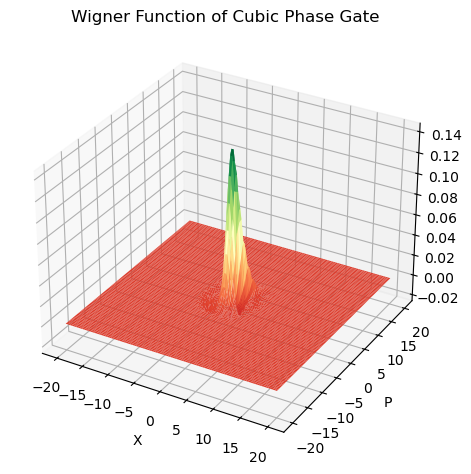

In [ ]:
prog = sf.Program(1)
with prog.context as q:
    Vac | q[0] # prepare the vacuum state |0>
    
    Vgate(gamma) | q[0] # apply the squeezing
    
    
eng = sf.Engine('fock', backend_options={"cutoff_dim": cutoff_dim}) 
state = eng.run(prog).state
plot_wigner(state, "Wigner Function of Cubic Phase Gate")